# Prepare calibration dataframe summary

This notebook serves the single purpose of building the energy sums and global compensation factors in regions of the HGCAL detector. The result is a dataframe with the final variables needed to run in a calibration loop.

To use spark do not forget to start the configuration with K8s and to connect to spark prior to any operation.

Author: P. Silva (psilva@cern.ch)
Date: 30/03/2021

In [19]:
import os
import ROOT
import PyRDF
import pandas as pd
import numpy as np
indir='/eos/cms/store/group/dpg_hgcal/tb_hgcal/2018/cern_h2_october/offline_analysis/sim_ntuples/CMSSW11_0_withAHCAL_newBeamline/QGSP_FTFP_BERT_EMN/v46/pions'
file_list=[os.path.join(indir,f) for f in os.listdir(indir) if 'ntuple_' in f]
outdir='/eos/cms/store/cmst3/user/psilva/HGCal/TB/2021Jun11'
os.system('mkdir -p {}'.format(outdir))

0

In [12]:
_tbSums={
    'CEESi':{'hit_lay':np.arange(0,28)},
    'CEHfineSi':{'hit_lay':np.arange(28,40)},
    'CEHSci':{'hit_lay':np.arange(40,63)},
}

def prepareCalibrationDataFrame(files,genId=-211,sum_defs=_tbSums,local=True):

    """
    wraps the procedure of selecting the events and collecting the necessary info in a small dataframe
    returns a pandas DataFrame.
    files - a list of files
    genId - the particle id to analyze
    sum_defs - the sum definitions (see previous cell for the definition of the dict)
    local - if True spark is not used
    """
    
    if local:
        ROOT.ROOT.EnableImplicitMT()
        PyRDF.use('local')
    else:
        PyRDF.use('spark', {'npartitions':12})
        files = ['root://eosuser.cern.ch/{}'.format(x) if x.find('root:')<0 else x for x in files]
            
    #define the selections and branches with an RDataFrame
    rdf = PyRDF.RDataFrame("rechitntupler/hits", files)
    
    rdf=rdf.Define('genId','pdgID') \
           .Define('genEn','beamEnergy') \
           .Define('genEt','genEn') \
           .Define('genEta','0*beamEnergy')
    
    #filter only the ids of interest
    rdf=rdf.Filter('genId=={}'.format(genId))    
    branchList=['genEn','genEt','genEta']
    
    #define energy sums and global compensation variables
    for s in sum_defs:
        
        #filter definition
        hit_sel = '({})'.format('||'.join( [ 'rechit_layer=={}'.format(l) for l in sum_defs[s]['hit_lay'] ] ) )
        print(s,hit_sel)
        
        #define additional variables of interest for calibration: 
        #hit energy in keV (hit_en_*) or in MIP units (hit_men_*) in the different sections received in sum_defs
        #sum of hit energies in GeV (sum_en_*) or in MIP units (sum_men_*)  ""  ""
        #cglob variable for global compensation (based on raw energy in MIP units)
        rdf=rdf.Define('hit_en_{}'.format(s),'rechit_energy[{}]'.format(hit_sel)) \
               .Define('hit_men_{}'.format(s),'rechit_energy[{}]'.format(hit_sel)) \
               .Define('sum_en_{}'.format(s),'1e-3*Sum(hit_en_{})'.format(s)) \
               .Define('sum_men_{}'.format(s),'Sum(hit_men_{})'.format(s))
        
        #append to final branchList
        branchList+=['sum_en_{}'.format(s)]
        
    return pd.DataFrame(rdf.AsNumpy(columns=branchList))

df=prepareCalibrationDataFrame(files=file_list[0:2],genId=-211,sum_defs=_tbSums,local=True)
df.head()

CEESi (rechit_layer==0||rechit_layer==1||rechit_layer==2||rechit_layer==3||rechit_layer==4||rechit_layer==5||rechit_layer==6||rechit_layer==7||rechit_layer==8||rechit_layer==9||rechit_layer==10||rechit_layer==11||rechit_layer==12||rechit_layer==13||rechit_layer==14||rechit_layer==15||rechit_layer==16||rechit_layer==17||rechit_layer==18||rechit_layer==19||rechit_layer==20||rechit_layer==21||rechit_layer==22||rechit_layer==23||rechit_layer==24||rechit_layer==25||rechit_layer==26||rechit_layer==27)
CEHfineSi (rechit_layer==28||rechit_layer==29||rechit_layer==30||rechit_layer==31||rechit_layer==32||rechit_layer==33||rechit_layer==34||rechit_layer==35||rechit_layer==36||rechit_layer==37||rechit_layer==38||rechit_layer==39)
CEHSci (rechit_layer==40||rechit_layer==41||rechit_layer==42||rechit_layer==43||rechit_layer==44||rechit_layer==45||rechit_layer==46||rechit_layer==47||rechit_layer==48||rechit_layer==49||rechit_layer==50||rechit_layer==51||rechit_layer==52||rechit_layer==53||rechit_layer

runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Define(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: GetBranchNames: error in opening the tree rechitntupler/hits
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Define(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: GetBranchNames: error in opening the tree rechitntupler/hits

Warning in <RTaskArenaWrapper>: CPU Bandwith Control Active. Proceeding with 2 threads accordingly
SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/cvmfs/sft.cern.ch/lcg/releases/spark/3.1.1-cern1-38186/x86_64-centos7-gcc8-opt/jars/slf4j-log4j12-1.7.30.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/cvmfs/sft.cern.ch/lcg/releases/hadoop/3.3.0-4a0f7/x86_64-centos7-gcc8-opt/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2021-06-14 21:43:22,035 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Warning in <TClass::Init>: no

******************************************************************************
*Tree    :hits      : HGC rechits                                            *
*Entries :    19901 : Total =      1905885362 bytes  File  Size =  569144765 *
*        :          : Tree compression factor =   3.35                       *
******************************************************************************
*Br    0 :event     : event/i                                                *
*Entries :    19901 : Total  Size=      81749 bytes  File Size  =      42167 *
*Baskets :       20 : Basket Size=      14801 bytes  Compression=   1.92     *
*............................................................................*
*Br    1 :trigger_timestamp : trigger_timestamp/l                            *
*Entries :    19901 : Total  Size=     161649 bytes  File Size  =       6281 *
*Baskets :       20 : Basket Size=      14801 bytes  Compression=  25.62     *
*...................................................

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


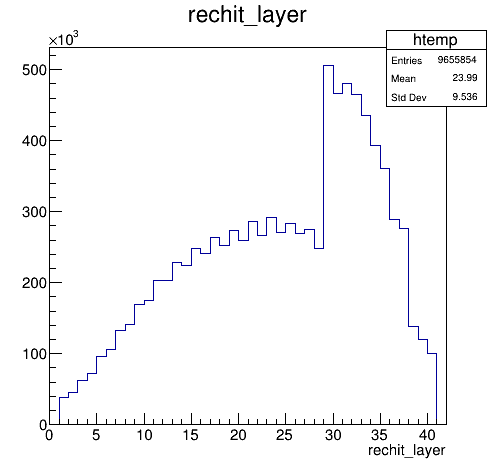

In [22]:
fIn=ROOT.TFile(file_list[3])
hits=fIn.Get('rechitntupler/hits')
c=ROOT.TCanvas('c','c',500,500)
hits.Draw('rechit_layer')
c.Draw()

## Detector regions

The dict below defines regions of detector which are to be analyzed separately (e.g. Si detectors in the fine part of CE-H).
Change the dict if you want to add/remove different regions. The hit_si/hit_lay will be used in the selection below.

In [ ]:
_tdrSums={
    'CEESi100':{'hit_si':True,
                'hit_sithick':1,
                'hit_lay':np.arange(1,29)},
    'CEESi200':{'hit_si':True,
                'hit_sithick':2,
                'hit_lay':np.arange(1,29)},
    'CEESi300':{'hit_si':True,
                'hit_sithick':3,
                'hit_lay':np.arange(1,29)},
    'CEHfineSi100':{'hit_si':True,
                    'hit_sithick':1,
                    'hit_lay':np.arange(29,41)},
    'CEHfineSi200':{'hit_si':True,
                    'hit_sithick':2,
                    'hit_lay':np.arange(29,41)},
    'CEHfineSi300':{'hit_si':True,
                    'hit_sithick':3,
                    'hit_lay':np.arange(29,41)},
    'CEHScifine':{'hit_si':False,
                 'hit_lay':np.arange(29,41)},
    'CEHcoarseSi100':{'hit_si':True,
                      'hit_sithick':1,
                      'hit_lay':np.arange(41,53)},
    'CEHcoarseSi200':{'hit_si':True,
                      'hit_sithick':2,
                      'hit_lay':np.arange(41,53)},
    'CEHcoarseSi300':{'hit_si':True,
                      'hit_sithick':3,
                      'hit_lay':np.arange(41,53)},
    'CEHScicoarse':{'hit_si':False,
                    'hit_lay':np.arange(41,53)},
    'CESifine':{'hit_si':True,
                'hit_lay':np.arange(1,41)},
    'CEHlast3':{'hit_lay':np.arange(50,53)},
    'CEHlast5':{'hit_lay':np.arange(48,53)},
}

_scenario13Sums={
    'CEESi100':{'hit_si':True,
                'hit_sithick':1,
                'hit_lay':np.arange(1,27)},
    'CEESi200':{'hit_si':True,
                'hit_sithick':2,
                'hit_lay':np.arange(1,27)},
    'CEESi300':{'hit_si':True,
                'hit_sithick':3,
                'hit_lay':np.arange(1,27)},
    'CEHfineSi100':{'hit_si':True,
                    'hit_sithick':1,
                    'hit_lay':np.arange(27,38)},
    'CEHfineSi200':{'hit_si':True,
                    'hit_sithick':2,
                    'hit_lay':np.arange(27,38)},
    'CEHfineSi300':{'hit_si':True,
                    'hit_sithick':3,
                    'hit_lay':np.arange(27,38)},
    'CEHScifine':{'hit_si':False,
                 'hit_lay':np.arange(27,38)},
    'CEHcoarseSi100':{'hit_si':True,
                      'hit_sithick':1,
                      'hit_lay':np.arange(38,48)},
    'CEHcoarseSi200':{'hit_si':True,
                      'hit_sithick':2,
                      'hit_lay':np.arange(38,48)},
    'CEHcoarseSi300':{'hit_si':True,
                      'hit_sithick':3,
                      'hit_lay':np.arange(38,48)},
    'CEHScicoarse':{'hit_si':False,
                    'hit_lay':np.arange(38,48)},
    'CESifine':{'hit_si':True,
                'hit_lay':np.arange(1,38)},
    'CEHlast3':{'hit_lay':np.arange(45,48)},
    'CEHlast5':{'hit_lay':np.arange(43,48)},
}
_sums={60:_tdrSums, 
       63:_tdrSums,
       69:_tdrSums,
       70:_scenario13Sums,
       73:_scenario13Sums,
       80:_scenario13Sums,
       83:_scenario13Sums}
_defaultSums=_tdrSums

## Hit analysis

The following defines a generic method to parse the ROOT tuples and produce the relevant variables.
Notice some of the methods are implemented in `utils/ShowerSelectionTools.h`

In [ ]:
def prepareCalibrationDataFrame(files,genId=-211,sum_defs=_defaultSums,local=False):

    """
    wraps the procedure of selecting the events and collecting the necessary info in a small dataframe
    returns a pandas DataFrame.
    files - a list of files
    genId - the particle id to analyze
    sum_defs - the sum definitions (see previous cell for the definition of the dict)
    local - if True spark is not used
    """
    
    if local:
        ROOT.ROOT.EnableImplicitMT()
        PyRDF.use('local')
    else:
        PyRDF.use('spark', {'npartitions':12})
        files = ['root://eosuser.cern.ch/{}'.format(x) if x.find('root:')<0 else x for x in files]
    
    PyRDF.include_headers("utils/ShowerSelectionTools.h")
        
    #define the selections and branches with an RDataFrame
    rdf = PyRDF.RDataFrame("hits", files)
    
    #filter only the ids of interest
    rdf=rdf.Filter('genId=={}'.format(genId))    
    branchList=['genEn','genEt','genEta']
    
    #define energy sums and global compensation variables
    for s in sum_defs:
        
        #filter definition
        hit_sel = '({})'.format('||'.join( [ 'hit_lay=={}'.format(l) for l in sum_defs[s]['hit_lay'] ] ) )
        if 'hit_si' in sum_defs[s]:
            hit_sel += ' && hit_si=={}'.format(int(sum_defs[s]['hit_si']))
        if 'hit_sithick' in sum_defs[s]:
            hit_sel += ' && (hit_sithick=={})'.format(int(sum_defs[s]['hit_sithick']))
        
        #define additional variables of interest for calibration: 
        #hit energy in keV (hit_en_*) or in MIP units (hit_men_*) in the different sections received in sum_defs
        #sum of hit energies in GeV (sum_en_*) or in MIP units (sum_men_*)  ""  ""
        #cglob variable for global compensation (based on raw energy in MIP units)
        rdf=rdf.Define('hit_en_{}'.format(s),'hit_en[{}]'.format(hit_sel)) \
               .Define('hit_men_{}'.format(s),'hit_men[{}]'.format(hit_sel)) \
               .Define('sum_en_{}'.format(s),'1e-3*Sum(hit_en_{})'.format(s)) \
               .Define('sum_men_{}'.format(s),'Sum(hit_men_{})'.format(s)) \
               .Define('cglob_{}'.format(s),'computeCglob(hit_men_{})'.format(s))
        
        #append to final branchList
        branchList+=['sum_en_{}'.format(s),'cglob_{}'.format(s)]
        
    return pd.DataFrame(rdf.AsNumpy(columns=branchList))

## Run the selection

Here you can play with whatever file list you need to process :)

In [ ]:
import re

regex=re.compile('Geant4_(.*)_version(.*)_')
icsregex=re.compile('icsmear(.*)_')
samples={}
samples_counts={}
for f in os.listdir(indir):
    
    if not '.root' in f: continue
    fullf=os.path.join(indir,f)

    #check if file is ok
    nhits=0
    try:
        fIn=ROOT.TFile.Open(fullf)
        nhits=fIn.Get('hits').GetEntriesFast()
        fIn.Close()
    except:
        nhits=-1
    if nhits<=0 : continue
    
    #add to samples list
    p=re.match(regex,f).group(1)
    v=re.match(regex,f).group(2)
    key=(p,v)
    try:
        ics=re.match(icsregex,f).group(1)
        key=(p,'{} ic:{}'.format(v,ics))
    except Exception as e:
        pass
    
    if not key in samples: 
        samples[key]=[]
        samples_counts[key]=0
    samples[key].append(fullf)
    samples_counts[key]+=nhits
    
for key,nhits in samples_counts.items():
    print('Particle={} version={} has {} hits'.format(*key,nhits))

In [ ]:
local=False

#iterate over the available samples
for key,flist in samples.items():
    
    genId=22 if key[0]=='gamma' else -211
    version=int(key[1].split('_')[0])
    sum_defs=_sums[version]

    out_f=os.path.join(outdir,'Geant4_{}_version{}.h5'.format(*key))
    df=prepareCalibrationDataFrame(flist,genId=genId,sum_defs=sum_defs,local=local)
    df.to_hdf(out_f, key='data', mode='w')
    
    print('{} created with shape={}'.format(out_f,df.shape))